# Qdrant & Image Data

Vector databases are a "relatively" new way for interacting with abstract data representations derived from opaque machine learning models -- deep learning architectures being the most common ones. These representations are often called vectors or embeddings and they are a compressed version of the data used to train a machine learning model to accomplish a task (e.g., sentiment analysis, speech recognition, object detection, and many more).

## Table of Contents

1. Overview
2. Set Up
3. Image Embeddings
4. Semantic Search
7. Conclusion

## 1. Overview

## 2. Set Up

Before you run any line of code, please make sure you have 
1. downloaded the data
2. created a virtual environment (if not in Google Colab)
3. installed the packages below
4. started a container with Qdrant

```bash
# with conda or mamba if you have it installed
mamba env create -n my_env python=3.10
mamba activate my_env

# or with virtualenv
python -m venv venv
source venv/bin/activate

# install packages
pip install qdrant-client transformers datasets pandas numpy torch librosa tensorflow openl3 panns-inference pedalboard
```

The open source version of Qdrant is available as a docker image and it can be pulled and run from any machine with docker installed. If you don't have Docker installed in your PC you can follow the instructions in the official documentation [here](https://docs.docker.com/get-docker/). After that, open your terminal start by downloading the image with the following command.

```sh
docker pull qdrant/qdrant
```

Next, initialize Qdrant with the following command, and you should be good to go.

```sh
docker run -p 6333:6333 \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant
```

Verify that you are ready to go by importing the following libraries and connecting to Qdrant via its Python client.

In [1]:
from datasets import load_dataset
from qdrant_client import QdrantClient
from qdrant_client.http import models
import numpy as np

In [29]:
client = QdrantClient(host="localhost", port=6333, prefer_grpc=True)

In [30]:
my_collection = "image_collection"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=768, distance=models.Distance.COSINE)
)

True

## 3. Image Embeddings

### 4.2 Computer Vision

In CV, vector databases are used to store image features. Image features are vector representations of images that capture their visual content. They are used to improve the performance of CV tasks such as object detection, image classification, and image retrieval.

In [4]:
dataset = load_dataset("marmal88/skin_cancer", split='train')
dataset

Found cached dataset parquet (/home/ramonperez/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
    num_rows: 9577
})

In [5]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'image_id': 'ISIC_0024329',
 'lesion_id': 'HAM_0002954',
 'dx': 'actinic_keratoses',
 'dx_type': 'histo',
 'age': 75.0,
 'sex': 'female',
 'localization': 'lower extremity'}

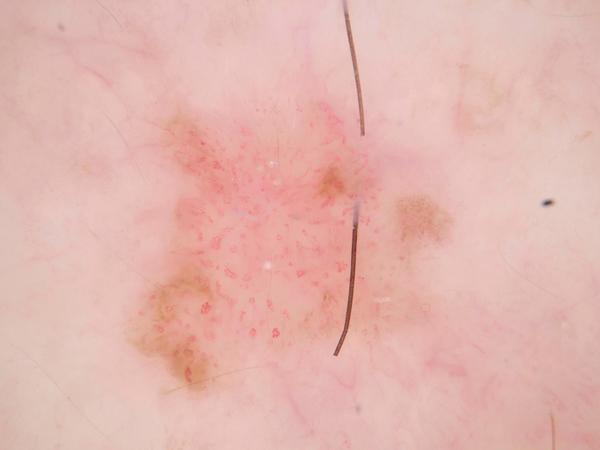

In [5]:
image = dataset[100]["image"]
image

In [6]:
from transformers import ViTImageProcessor, ViTModel

processor = ViTImageProcessor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
last_hidden_states


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[[ 1.3790,  0.0280, -0.4497,  ...,  2.3587, -1.4499, -1.6071],
         [ 1.6822,  1.1798, -0.1015,  ...,  3.4339, -2.0893,  1.4966],
         [ 0.4055,  3.0090, -1.4294,  ...,  0.7934,  0.9956,  0.1239],
         ...,
         [-0.9456, -1.4407,  0.4994,  ..., -0.5065, -1.3028, -1.0159],
         [ 0.2939, -2.4869, -0.3513,  ..., -3.0422, -0.9645,  1.4452],
         [ 0.1314,  0.5851, -2.1364,  ...,  1.3084, -1.2818,  0.3008]]],
       grad_fn=<NativeLayerNormBackward0>)

In [8]:
last_hidden_states.mean(dim=1).shape

torch.Size([1, 768])

In [13]:
def get_embeddings(batch):
    inputs = processor(images=batch['image'], return_tensors="pt")
    outputs = model(**inputs).last_hidden_state.mean(dim=1)
    batch['embeddings'] = outputs
    return batch

In [14]:
dataset = dataset.map(get_embeddings, batched=True, batch_size=32)

Map:   0%|          | 0/9577 [00:00<?, ? examples/s]

In [15]:
dataset

Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'embeddings'],
    num_rows: 9577
})

In [6]:
dataset.select_columns([
            'dx', 'dx_type', 'age', 'sex', 'localization'
        ]).to_pandas().head().to_dict(orient="records")

[{'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 75.0,
  'sex': 'female',
  'localization': 'lower extremity'},
 {'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 70.0,
  'sex': 'male',
  'localization': 'lower extremity'},
 {'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 75.0,
  'sex': 'female',
  'localization': 'lower extremity'},
 {'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 50.0,
  'sex': 'male',
  'localization': 'upper extremity'},
 {'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 50.0,
  'sex': 'male',
  'localization': 'upper extremity'}]

In [21]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'image_id': 'ISIC_0024329',
 'lesion_id': 'HAM_0002954',
 'dx': 'actinic_keratoses',
 'dx_type': 'histo',
 'age': 75.0,
 'sex': 'female',
 'localization': 'lower extremity',
 'embeddings': [-0.2680734694004059,
  0.9514418244361877,
  -0.10934426635503769,
  -0.134081169962883,
  0.25033503770828247,
  0.5232077240943909,
  -0.7412128448486328,
  0.5387338995933533,
  0.3570750951766968,
  0.38689833879470825,
  2.111851930618286,
  -2.337908983230591,
  0.767090916633606,
  0.42580780386924744,
  -0.20215392112731934,
  0.7705738544464111,
  -0.015396260656416416,
  0.4011093080043793,
  0.016566548496484756,
  0.5008870363235474,
  1.4052575826644897,
  -0.14093220233917236,
  -0.45457279682159424,
  -0.32580602169036865,
  0.8182810544967651,
  -0.9696608781814575,
  1.2217622995376587,
  -0.42826271057128906,
  0.6812717318534851,
  -0.5257284641265869,
  -0.8782455325126648,
  -0.045010726898908615,
  0.45

In [7]:
ids = list(range(dataset.num_rows))
payload = dataset.select_columns([
            'dx', 'dx_type', 'age', 'sex', 'localization'
        ]).to_pandas().to_dict(orient="records")
embeddings = np.load("vecs.npy").tolist()
# embeddings.shape

In [14]:
for pay in payload:
    if type(pay['localization']) != str:
        print(pay)

In [6]:
dataset.num_rows, len(embeddings), len(payload), len(ids)

(9577, 9577, 9577, 9577)

In [31]:
client.count(
    collection_name=my_collection, 
    exact=True,
)

CountResult(count=0)

In [20]:
payload[1662], payload[1663], payload[1664], payload[1665]

({'dx': 'benign_keratosis-like_lesions',
  'dx_type': 'histo',
  'age': 60.0,
  'sex': 'male',
  'localization': 'lower extremity'},
 {'dx': 'benign_keratosis-like_lesions',
  'dx_type': 'consensus',
  'age': 85.0,
  'sex': 'male',
  'localization': 'back'},
 {'dx': 'benign_keratosis-like_lesions',
  'dx_type': 'consensus',
  'age': 80.0,
  'sex': 'male',
  'localization': 'trunk'},
 {'dx': 'benign_keratosis-like_lesions',
  'dx_type': 'histo',
  'age': 75.0,
  'sex': 'male',
  'localization': 'face'})

In [23]:
embeddings[1662], #embeddings[1663], embeddings[1664], embeddings[1665]

([0.07595458626747131,
  0.19018149375915527,
  -0.5471720695495605,
  0.2714891731739044,
  0.4721663296222687,
  1.526262879371643,
  0.17430171370506287,
  0.47115498781204224,
  0.44883647561073303,
  0.044410254806280136,
  0.7728936076164246,
  -1.5969781875610352,
  -0.12186454981565475,
  0.20109662413597107,
  -0.19859455525875092,
  0.558887243270874,
  -0.32992762327194214,
  1.014947772026062,
  0.6226453185081482,
  0.07925383001565933,
  0.2589719891548157,
  -0.012616370804607868,
  -1.2178962230682373,
  -0.9005835652351379,
  0.3059513568878174,
  0.4045252501964569,
  0.21382556855678558,
  -0.8259721994400024,
  -0.1597202718257904,
  0.2508302628993988,
  -0.49170151352882385,
  -0.784965455532074,
  0.4315185844898224,
  -0.24090173840522766,
  -0.46198734641075134,
  0.5353673696517944,
  -0.017423201352357864,
  0.712128758430481,
  0.5735445022583008,
  -0.9285837411880493,
  -0.10805724561214447,
  -0.3316769003868103,
  -0.0226550605148077,
  0.624480724334716

In [32]:
client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=ids,
            vectors=embeddings,
            payloads=payload
        )
    )

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses; last error: UNKNOWN: ipv4:127.0.0.1:6334: Failed to connect to remote host: Connection refused"
	debug_error_string = "UNKNOWN:failed to connect to all addresses; last error: UNKNOWN: ipv4:127.0.0.1:6334: Failed to connect to remote host: Connection refused {grpc_status:14, created_time:"2023-06-02T16:15:41.677549977+08:00"}"
>

In [37]:
np.save("vecs", np.array(embeddings), allow_pickle=False)

In [ ]:
for i in tqdm(range(0, len(audios), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(audios))
    # extract batch
    batch = audios[i:i_end]
    # generate embeddings for all the audios in the batch
    _, emb = model.inference(batch)
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb.tolist()))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

In [7]:
models.PointIdsList??

Init signature: models.PointIdsList(*, points: List[ForwardRef('ExtendedPointId')]) -> None
Source:        
class PointIdsList(BaseModel):
    points: List["ExtendedPointId"] = Field(..., description="")
File:           ~/anaconda/envs/qdrant101/lib/python3.10/site-packages/qdrant_client/http/models/models.py
Type:           ModelMetaclass
Subclasses:     

In [26]:
batch_size = 1000

for i in range(0, dataset.num_rows, batch_size):

    low_idx = min(i+batch_size, dataset.num_rows)

    batch_of_ids = ids[i: low_idx]
    batch_of_embs = embeddings[i: low_idx]
    batch_of_payloads = payload[i: low_idx]

    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=batch_of_ids,
            vectors=batch_of_embs,
            payloads=batch_of_payloads
        )
    )

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses; last error: UNKNOWN: ipv4:127.0.0.1:6334: Failed to connect to remote host: Connection refused"
	debug_error_string = "UNKNOWN:failed to connect to all addresses; last error: UNKNOWN: ipv4:127.0.0.1:6334: Failed to connect to remote host: Connection refused {created_time:"2023-06-02T16:13:36.367760674+08:00", grpc_status:14}"
>

In [ ]:
client.scroll()

## 4. Semantic Search

## 5. Conclusion